## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [3]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import gmres, LinearOperator
from operators.stokes_operator import StokesAdjointBoundaryOp
from util.unet import *

In [2]:
class MicroGeom(GaussLegGeometry):
    def __init__(self, func, dfunc, ddfunc, width, height, line_pos, n_refine, n_corner_refine):
        
        # parameterise func 
        f = lambda t: func(t)*1j + width * t / dom[1]
        df = lambda t: dfunc(t)*1j + width / dom[1]
        ddf = lambda t: ddfunc(t)*1j
        
        # Define segments to stitch
        dom = np.linspace(0,2*np.pi,5)
        pts = [f(dom[1]), width + height*1j, height*1j, f(dom[0])]
        z, dz, ddz = [f], [df], [ddf]
        
        for i in range(3):
            r, dr, ddr = GaussLegGeometry.get_line_2d(pts[i], pts[i+1], dom[i+1], dom[i+2])
            z.append(r)
            dz.append(dr)
            ddz.append(ddr)
        
        # Stitch segments together
        z = GaussLegGeometry.stitch_functions_1d(z, dom)
        dz = GaussLegGeometry.stitch_functions_1d(dz, dom)
        ddz = GaussLegGeometry.stitch_functions_1d(ddz, dom)
        
        # Define grid
        grid = GaussLegGrid(dom, np.ones((5,)).astype(int))
        grid.refine_all_nply(n_refine)
        grid.refine_corners_nply(n_corner_refine)
        
        # Main properties
        self.width = width
        self.line_pos = line_pos
        super().__init__([z, dz, ddz], grid)
    
    
    def get_inner_pt(self):
        """Overwrite inner_point to be independent of lower boundary."""
        return self.width/2 + self.line_pos * 1j
    
    def precompute_line_avg(self, derivative=0, **kwargs):
        return super().precompute_line_avg(0.05*self.width + self.line_pos * 1j, 0.95*self.width + self.line_pos*1j, derivative, **kwargs)

NameError: name 'GaussLegGeometry' is not defined

In [19]:
class GPDomain(MicroGeom):
    def __init__(self, kernel, shape, scale, num, bound=None, X=None, Y=None, K_inv_dy=None, **kwargs):
        
        self.k, self.dk, self.ddk = self.get_kernel(kernel, scale, shape)
        width = kwargs["width"]
        
        if (X is None):
            X, Y, K_inv_dy = self.sample_bounded_gp(self.k, width, bound, num)
            
        r = width / (0.5 * np.pi)
        y = lambda t: K_inv_dy.T @ self.k(r*t, X)
        dy = lambda t: K_inv_dy.T @ self.dk(r*t, X)*r
        ddy = lambda t: K_inv_dy.T @ self.ddk(r*t, X)*r**2
        
        # Data that is used in function methods.
        self.X = X
        self.Y = Y
        
        # Hidden data
        self.kwargs = kwargs
        self.data = {"kernel": kernel,
                     "shape": shape,
                     "scale": scale,
                     "num": num,
                     "Y": Y,
                     "X": X,
                     "K_inv_dy": K_inv_dy}
        super().__init__(y, dy, ddy, **kwargs)
    
    def save(self, path):
        data = self.data.copy()
        data.update(self.kwargs)
        torch.save(data, path)
    
    def plot(self, show_samples=True, show_hline=True, **kwargs):
        super().plot(**kwargs)
        color = kwargs.pop("color", "black")
        ax = kwargs.pop("ax")
        if show_hline:
            ax.plot([0.05*self.width, 0.95*self.width],[self.line_pos, self.line_pos], linewidth=4, color=color)
        if show_samples:
            ax.scatter(self.X, self.Y)
            #plt.scatter(self.X, self.K_inv_df)
    
    @staticmethod
    def load(path, **kwargs):
        if type(path) == str:
            data = torch.load(path)
        elif type(path) == dict:
            data = path
        gp_dom = GPDomain(**data)
        return gp_dom
    
    @staticmethod
    def get_kernel(name, scale, shape):
        if name == "exp":
            # Do smth else
            k = lambda x, y: scale * np.exp(-((x - y) ** 2) / shape)
            dk = lambda x, y: - 2 / shape * (x - y) * k(x, y)
            ddk = lambda x, y: - 2 / shape * (1 - 2 / shape * (x - y)**2) * k(x, y)
        else:
            assert False,f"Kernel {name} not implemented"
        return k, dk, ddk
    
    @staticmethod
    def sample_bounded_gp(k, width, bound, num, resample=0):
            X = np.linspace(-0.1*width, 1.1*width, num)[:,None]#np.sort(np.random.uniform(-0.1*width, 1.1*width, num))[:,None]
            K = k(X, X.T)
            Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), K)[:, None]
            K_inv_dy = np.linalg.solve(K, Y)
            
            #print(K_inv_dy)
            if np.max(np.abs(Y)) >= bound:
                print(f"Resample # {resample}", end="\r")
                return GPDomain.sample_bounded_gp(k, width, bound, num, resample+1)
            else:
                return X, Y, K_inv_dy
            

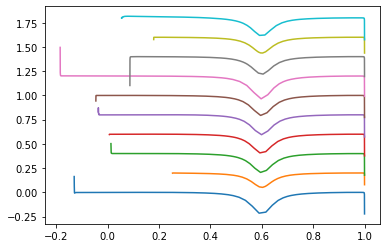

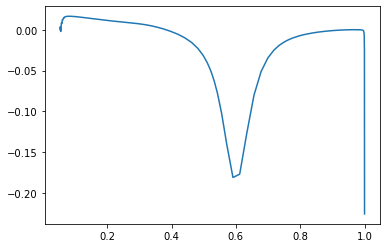

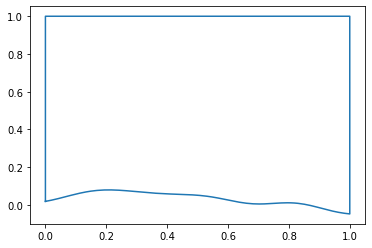

In [66]:
N = 10
for i in range(N):
    data = torch.load(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_2/domain_{i}.GPDomain")
    rv = data.pop("riesz_vec")
    rv2 = data.pop("riesz_vec_der")
    geom = GPDomain.load(data)
    t, _ = geom.grid.get_grid_and_weights()
    z = geom.eval_param()
    #plt.figure()
    #geom.plot(ax=plt.gca())

    #plt.figure()
    #plt.plot(np.imag(rv))
    if i == 0:
        rmean = np.zeros_like(rv)
        zmean = np.zeros_like(z)
    #if np.real(rv)[100]<0.2:
    if np.abs(np.real(rv)[-50])>0.02:
        print(i)
    rmean += rv / N
    zmean += z/N
    plt.plot(np.imag(z)[-len(t)//4:], np.real(rv)[-len(t)//4:]+i/5)
    #plt.ylim([-0.5,0.5])

plt.figure()
#plt.plot(np.imag(z), np.real(rmean), linewidth=2)
#plt.plot(np.imag(z), np.imag(rmean), linewidth=2)
r0 = np.real(rv)[-len(t)//4]
r = np.real(rv)[-len(t)//4:]#-r0
x = np.imag(z)[-len(t)//4:]
#plt.plot(np.log(1-x), np.log(r), 'b*')
plt.plot(x, r)
#plt.xlim([0.9,1.01])
#plt.xlim([-8,-4])
#plt.ylim([-1.75,-1.4])

plt.figure()
plt.plot(np.real(zmean), np.imag(zmean))


0, dy=0.00, c=889.69998320819792
1705.8317836723884


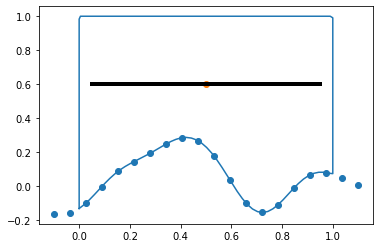

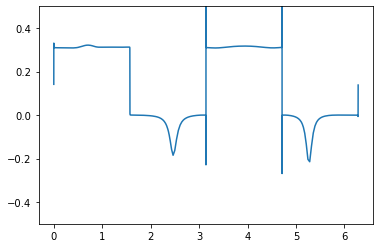

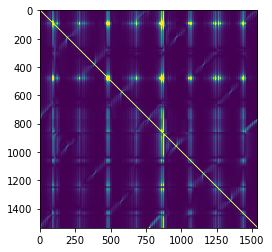

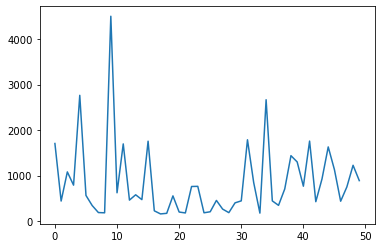

In [16]:
i = 0
dymin = 1.
c = []
for i in range(50):
    data = torch.load(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_3/domain_{i}.GPDomain")
    rv = data.pop("riesz_vec")
    rv2 = data.pop("riesz_vec_der")
    geom = GPDomain.load(data)
    #rv, _ = geom.precompute_line_avg(tol=1e-10, maxiter=1000, verbose=True)
        
    c.append(np.linalg.cond(geom.stokes_matrix()))

    #plt.figure()
    #geom.plot(ax=plt.gca())
    dy = np.abs(np.imag(geom.get_inner_pt())-0.6)
    print(f"{i}, dy={dy}, c={c[-1]}", end="\r")
    if dy < dymin:
        dymin = dy
        j = i

print(f"{j}, dy={dymin}")

data = torch.load(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_2/domain_{j}.GPDomain")
rv = data.pop("riesz_vec")
rv2 = data.pop("riesz_vec_der")
geom = GPDomain.load(data)

z0 = geom.get_inner_pt()

plt.figure()
geom.plot(ax=plt.gca())
plt.scatter(np.real(z0), np.imag(z0))

plt.figure()
plt.plot(t,np.real(rv))
plt.ylim([-0.5,0.5])

plt.figure()
K = geom.stokes_matrix()
print(np.linalg.cond(K))
plt.imshow(np.abs(K), vmin=0, vmax=.1)

plt.figure()
plt.plot(c)

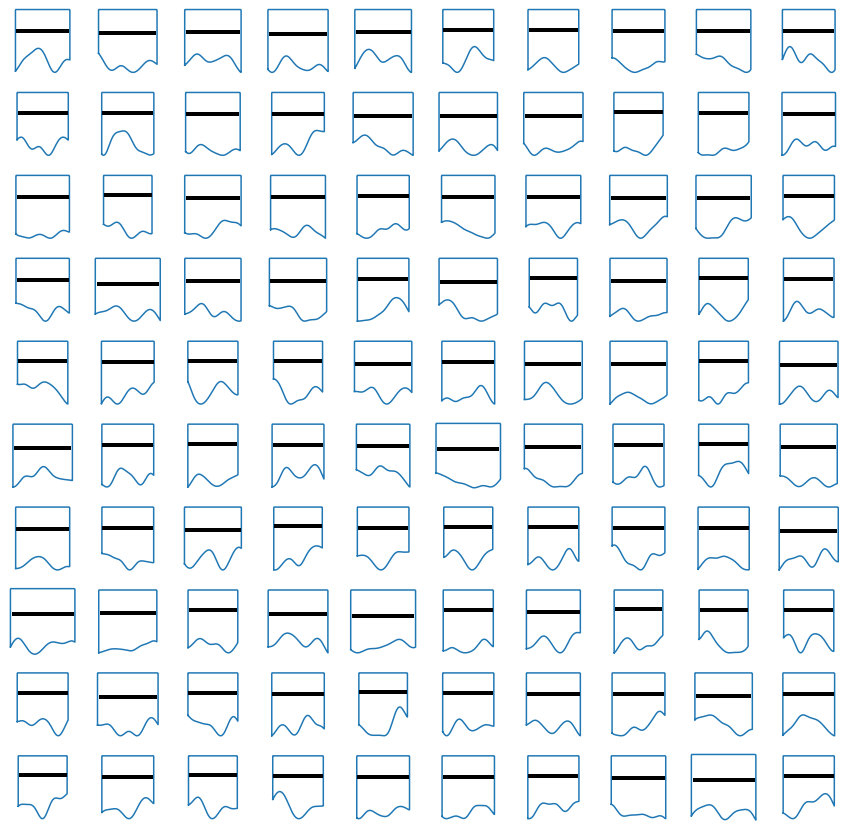

In [6]:
N = 10
plt.figure(figsize=(15,15))
for i in range(N*N):
    data = torch.load(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_2/domain_{i}.GPDomain")
    rv = data.pop("riesz_vec")
    rv2 = data.pop("riesz_vec_der")
    geom = GPDomain.load(data)
    
    plt.subplot(N, N, i+1)
    geom.plot(ax=plt.gca(), show_samples=False)
    plt.axis("equal")
    remove_axes(plt.gca())